# **Retrieval Augmented Generation (RAG)**

## **Why do we need RAG?**

* LLMs have the following limitations:
    - They can't access private data.
    - They can't answer about events which happened after the cut-off date of their pretraining data.
    - In short, their parametric knowledge is limited to pretraining data.
    - They tend to hallucinate and confidently generate wrong information.

* How can we solve the above issues?
    - LLM Fine tuning - Computationally expensive and needs deep expertise.
    - In Context Learning (ICL) - Heavily dependent on prompt engineering and exemplar selection.
    - Retrieval Augmented Generation (RAG) - Cheaper and safer.

## **What are the Componenets of RAG?**

**Indexing**

* Document Ingestion
* Chunking
* Embeddings
* Vector Store



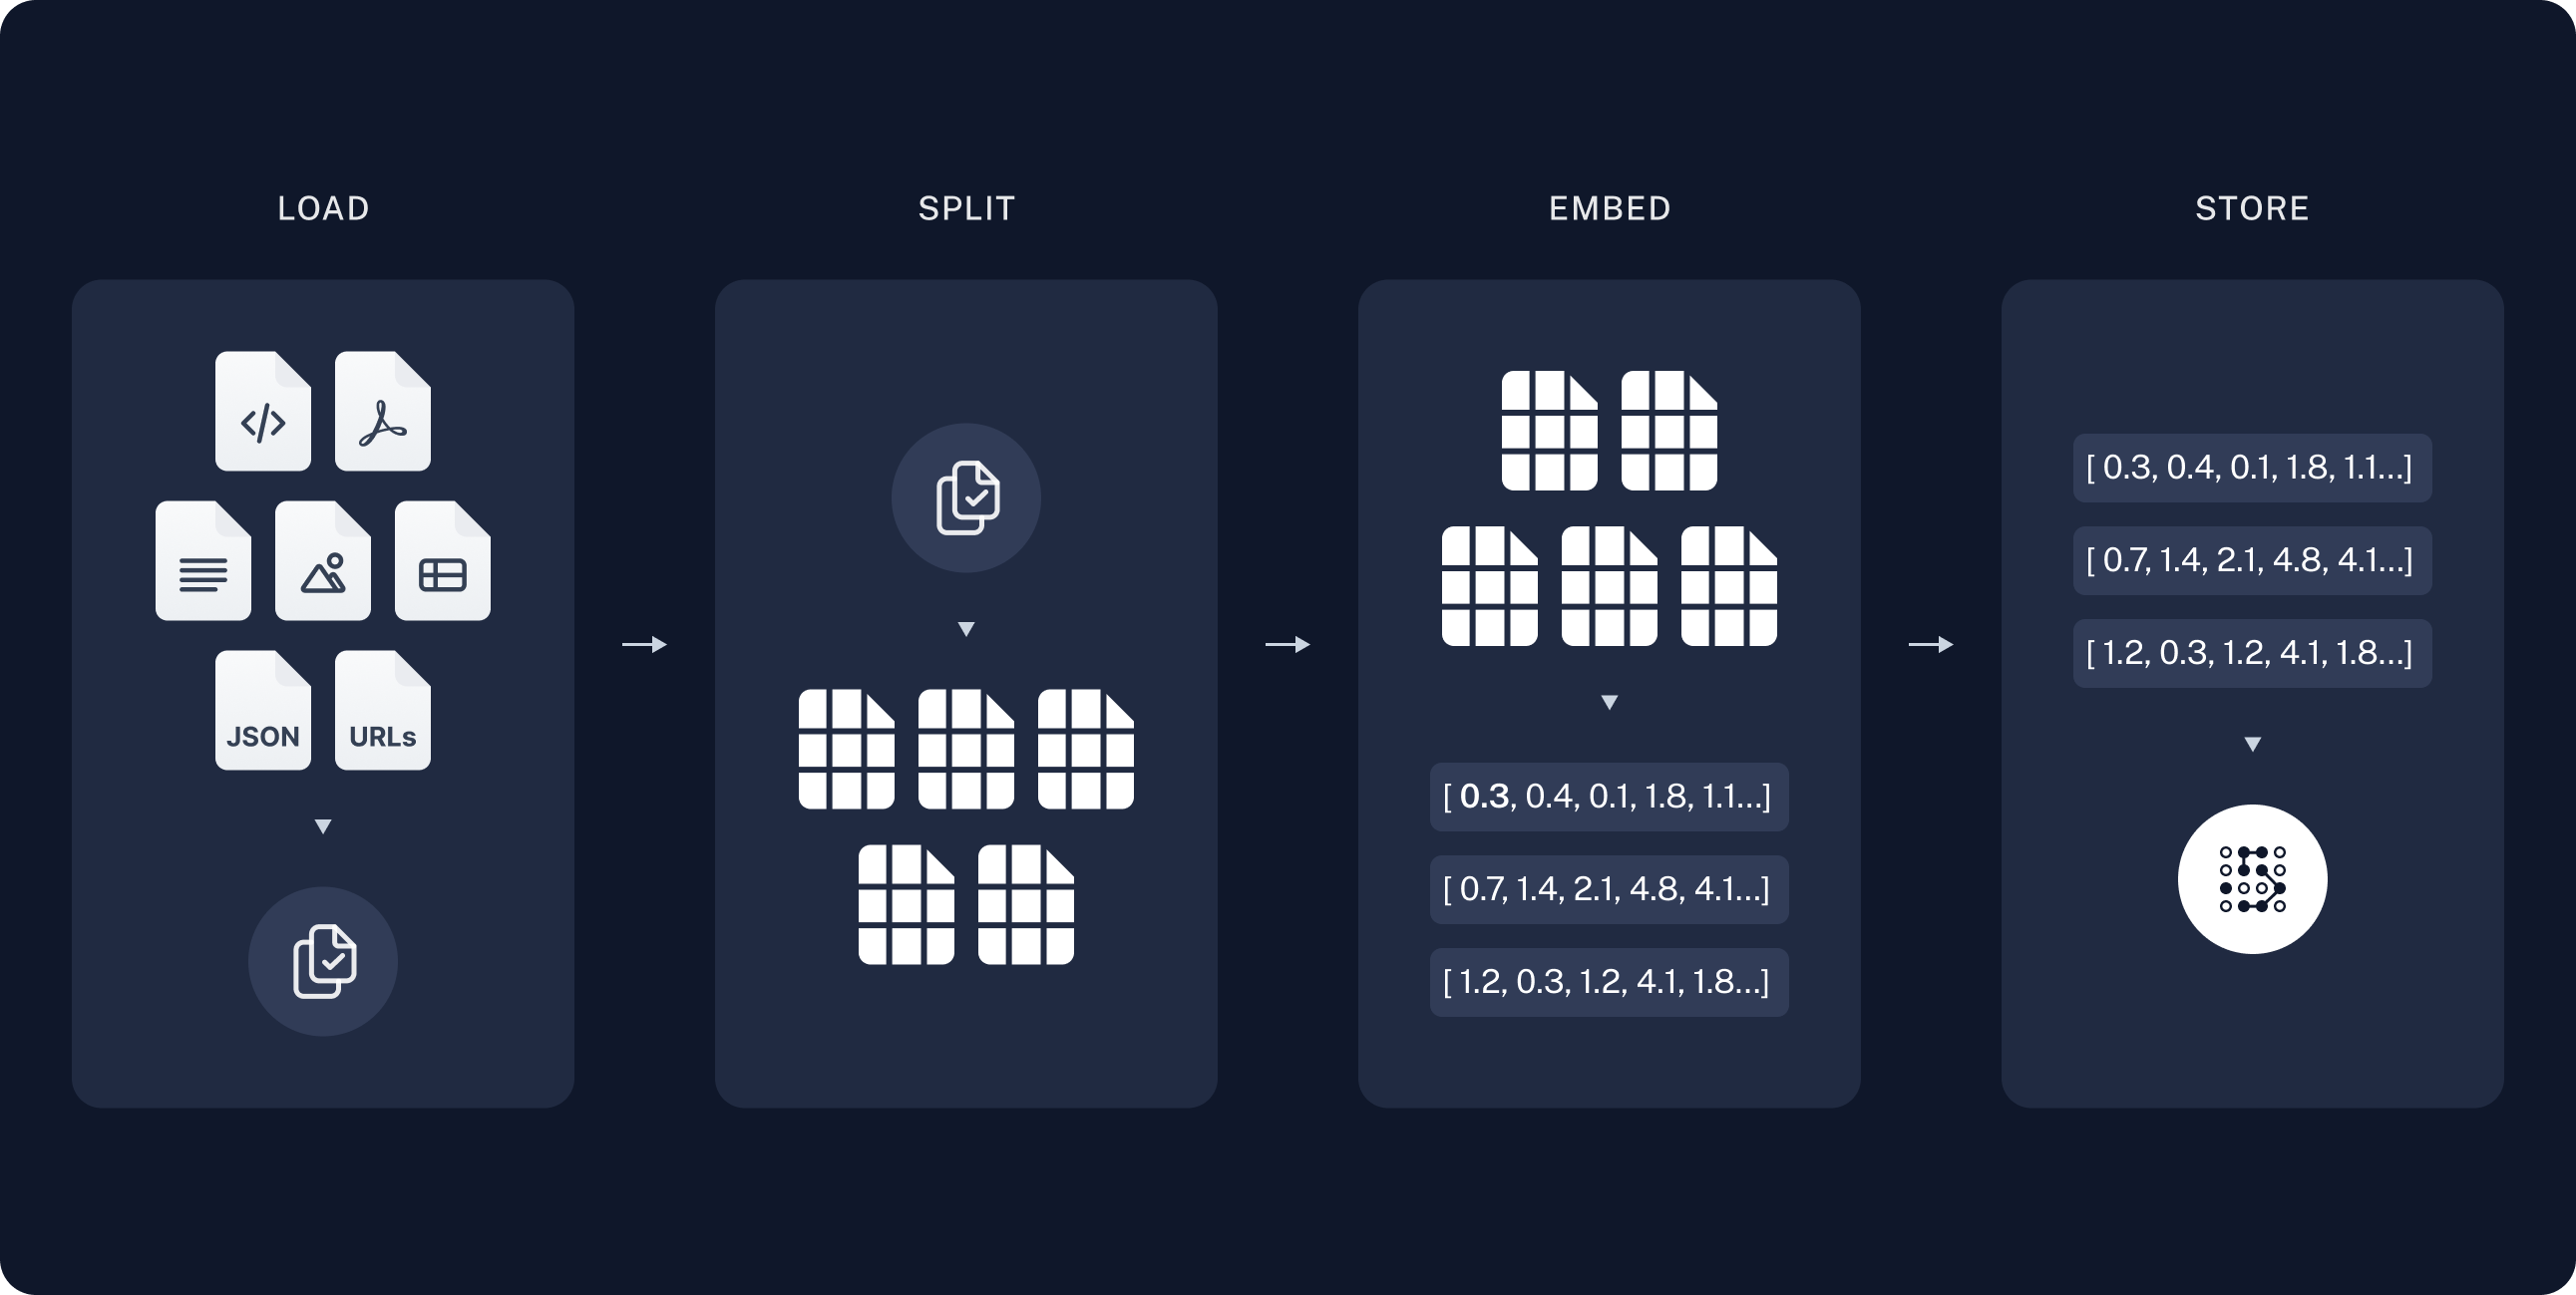



* **Retrieval**
    - Query embedding
    - Semantic Search
    - Ranking

* **Augmentation**
* **Generation**



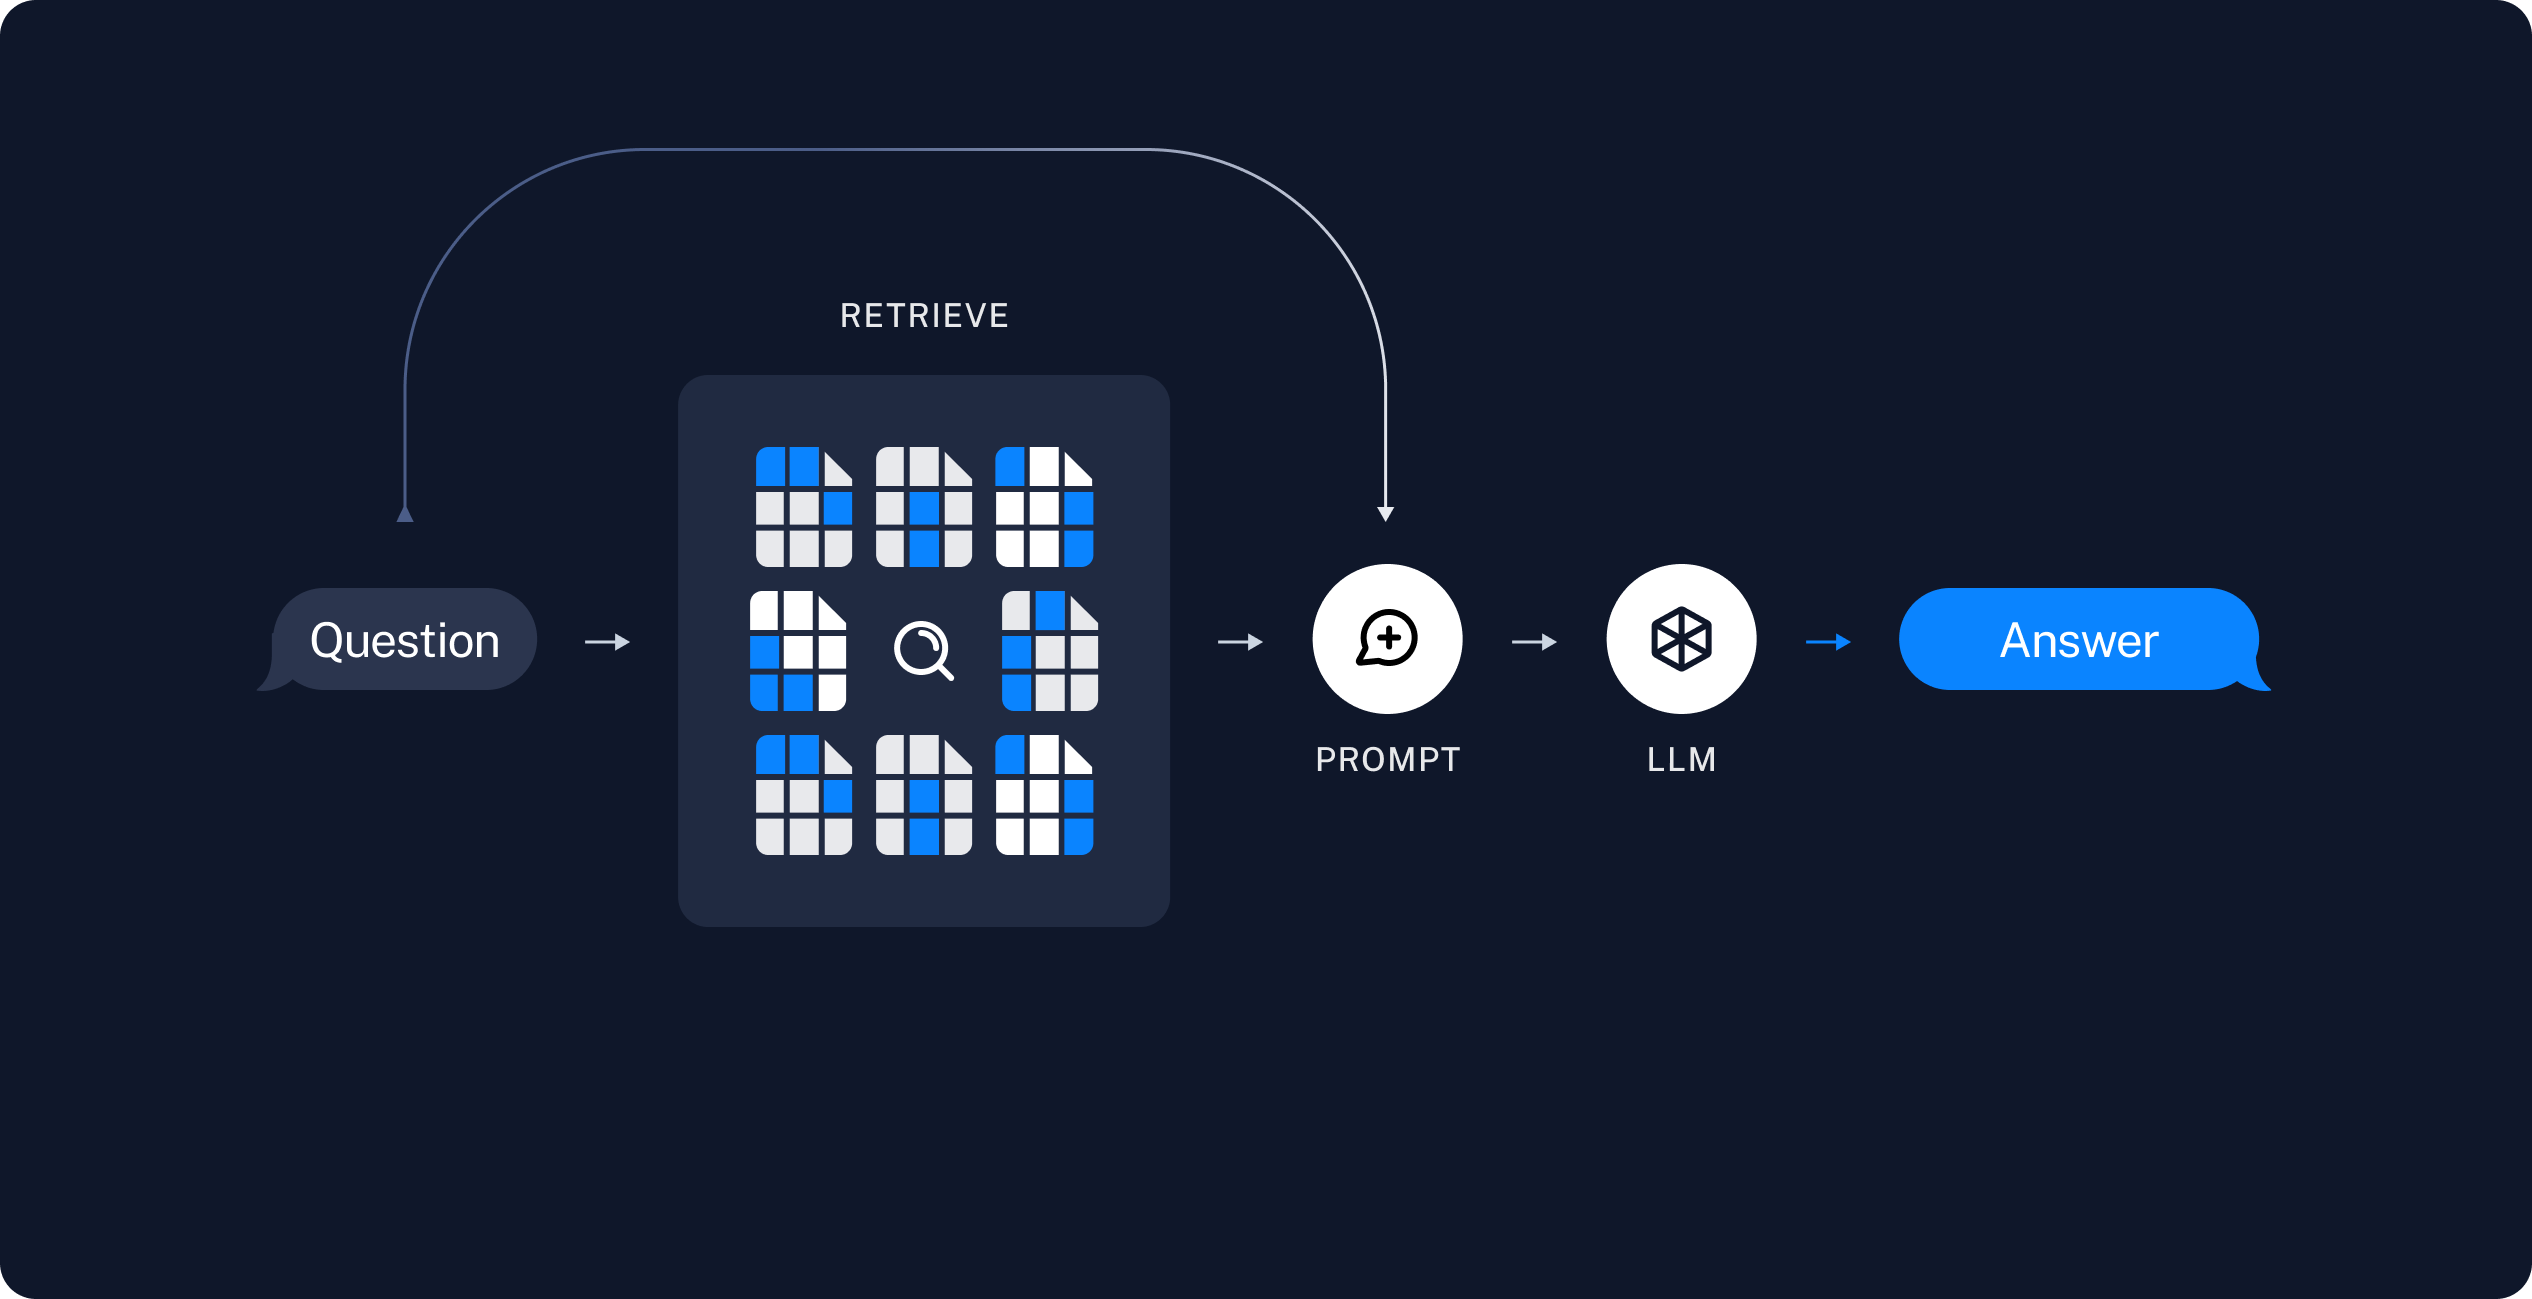

## **What is LangChain?**

LangChain is a framework for developing applications powered by large language models (LLMs). LangChain implements a standard interface for LLMs and related technologies, such as embedding models and vector stores, and integrates with hundreds of providers. It helps AI developers connect LLMs such as GPT-4 with external data and computation.

Key benefits include:

1. **Modular Workflow**: Simplifies chaining LLMs together for reusable and efficient workflows.
2. **Prompt Management**: Offers tools for effective prompt engineering and memory handling.
3. **Ease of Integration**: Streamlines the process of building LLM-powered applications.











### **Components of LangChain**

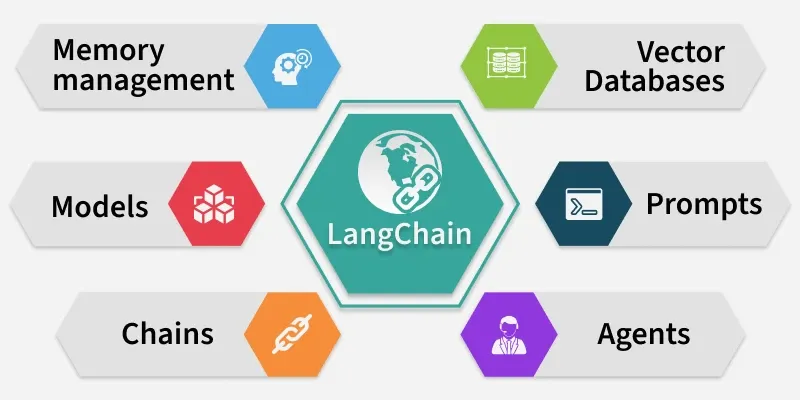

1. **Chains**: Chains define sequences of actions, where each step can involve querying an LLM, manipulating data or interacting with external tools. There are two types:

2. **Prompt Management**: LangChain facilitates managing and customizing prompts passed to the LLM. Developers can use **PromptTemplates** to define how inputs and outputs are formatted before being passed to the model. It also simplifies tasks like handling dynamic variables and prompt engineering, making it easier to control the LLM's behavior.

3. **Agents**: Agents are autonomous systems within LangChain that take actions based on input data. They can call external APIs or query databases dynamically, making decisions based on the situation. These agents leverage LLMs for decision-making, allowing them to respond intelligently to changing input.

4. **Vector Database**: LangChain integrates with a vector database which is used to store and search high-dimensional vector representations of data. This is important for performing similarity searches, where the LLM converts a query into a vector and compares it against the vectors in the database to retrieve relevant information.

5. **Models**: LangChain is model-agnostic meaning it can integrate with different LLMs such as OpenAI's GPT, Hugging Face models, DeepSeek R1 and more. This flexibility allows developers to choose the best model for their use case while benefiting from LangChain’s architecture.

6. **Memory Management**: LangChain supports memory management allowing the LLM to "remember" context from previous interactions. This is especially useful for creating conversational agents that need context across multiple inputs. The memory allows the model to handle sequential conversations, keeping track of prior exchanges to ensure the system responds appropriately.

## **What is FAISS?**

**Facebook AI Similarity Search** (FAISS) is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. FAISS achieves speed and efficiency by using techniques like indexing (e.g., Inverted File Index) and quantization (e.g., Product Quantization) to organize and compress vectors.

## **FAISS Vs ChromaDB**

FAISS and ChromaDB are both libraries that serve the purpose of managing and querying large-scale vector databases, but they have different focuses and characteristics.



*   **ChromaDB** is specifically designed for managing and searching large-scale color data, particularly in the context of computer vision and image processing. It is optimized for working with color histograms and other color-based representations.
    - Use Case: ChromaDB is commonly used in applications where color plays a crucial role, such as image and video processing, where similarity searches based on color are essential.
*   **FAISS** is a more general-purpose library designed for similarity search in large-scale vector databases. It is not limited to any specific type of data and can be applied to a wide range of applications. It is highly optimized for speed and memory usage, making it suitable for handling large datasets efficiently.
    - Use Case: FAISS is widely used in applications where similarity search is critical, such as recommendation systems, natural language processing, and image retrieval. Its versatility makes it suitable for handling different types of vector data.





## **Building a Youtube ChatBot**

In [ ]:
# OPEN_AI_KEY
key = '... your openai key here ...'

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = key

### **Install libraries**

In [ ]:
# !pip install  youtube-transcript-api langchain-community langchain-huggingface langchain-ollama faiss-cpu tiktoken python-dotenv

# !pip install langchain-openai
# %pip install python-dotenv

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
#from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate

### **Install Ollama and Pull Required LLMs and Embedding Models**

In [ ]:
# !curl -fsSL https://ollama.com/install.sh | sh
# !curl -fsSL https://ollama.com/install.sh | sudo -n sh
!sudo -n curl -fsSL https://ollama.com/install.sh | sudo -n sh

In [ ]:
import subprocess
import threading

def ollama_serve():
    subprocess.run(["ollama", "serve"])

ollama_thread = threading.Thread(target=ollama_serve)
ollama_thread.start()

In [ ]:
!ollama pull nomic-embed-text

In [ ]:
!ollama pull llama3.2:1b

In [ ]:
!ollama pull deepseek-r1:1.5b

In [ ]:
!ollama pull qwen3:1.7b

### **Step 1a - Indexing (Document Ingestion)**

In [ ]:
video_id = "giT0ytynSqg" # only the ID, not full URL
try:
    # If you don’t care which language, this returns the “best” one
    ytt_api = YouTubeTranscriptApi()
    transcript_list = ytt_api.fetch(video_id=video_id, languages=["en"])
    transcript_list = transcript_list.to_raw_data()

    # Flatten it to plain text
    transcript = " ".join(chunk["text"] for chunk in transcript_list)
    print(transcript)

except TranscriptsDisabled:
    print("No captions available for this video.")

In [ ]:
transcript_list[:10]

### **Step 1b - Indexing (Text Splitting)**

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.create_documents([transcript])

In [ ]:
len(chunks)

In [ ]:
chunks[100]

### **Step 1c & 1d - Indexing (Embedding Generation and Storing in Vector Store)**

In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
# embeddings = OllamaEmbeddings(model='nomic-embed-text')

vector_store = FAISS.from_documents(chunks, embeddings)

In [ ]:
vector_store.index_to_docstore_id

In [ ]:
vector_store.get_by_ids(['88a55002-c2f7-4744-b97b-c32f550d8a0b'])

### **Step 2 - Retrieval**

In [ ]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [ ]:
retriever

In [ ]:
retriever.invoke('What is deepmind')

### **Step 3 - Augmentation**

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

# llm = ChatOllama(model="llama3.2:1b")
# llm = ChatOllama(model="deepseek-r1:1.5b")
#llm = ChatOllama(model="qwen3:1.7b")

In [ ]:
prompt = PromptTemplate(
    template="""
      You are a helpful assistant.
      Answer ONLY from the provided transcript context.
      If the context is insufficient, just say you don't know.

      {context}
      Question: {question}
    """,
    input_variables = ['context', 'question']
)

In [ ]:
#question          = "is the topic of nuclear fusion discussed in this video? if yes then what was discussed"
question          = "is invention of the atomic bomb discussed in this video? if yes then what was discussed"

retrieved_docs    = retriever.invoke(question)

In [ ]:
retrieved_docs

In [ ]:
context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
context_text

In [ ]:
final_prompt = prompt.invoke({"context": context_text, "question": question})

In [ ]:
final_prompt

### **Step 4 - Generation**

In [ ]:
answer = llm.invoke(final_prompt)
print(answer.content)

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [ ]:
def format_docs(retrieved_docs):
  context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
  return context_text

In [ ]:
parallel_chain = RunnableParallel({
    'context': retriever | RunnableLambda(format_docs),
    'question': RunnablePassthrough()
})

In [ ]:
parallel_chain.invoke('who is Demis')

In [ ]:
parser = StrOutputParser()

In [ ]:
main_chain = parallel_chain | prompt | llm | parser

In [ ]:
main_chain.invoke('Can you summarize the video')

RAG PDF Dataset: https://github.com/laxmimerit/rag-dataset

### **Install Libraries**

In [ ]:
!pip install -U langchain-community faiss-cpu langchain-huggingface pymupdf tiktoken langchain-ollama python-dotenv

In [ ]:
import os
import warnings
from dotenv import load_dotenv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

load_dotenv()

In [ ]:
os.environ['LANGCHAIN_PROJECT']

### **Document Loader**

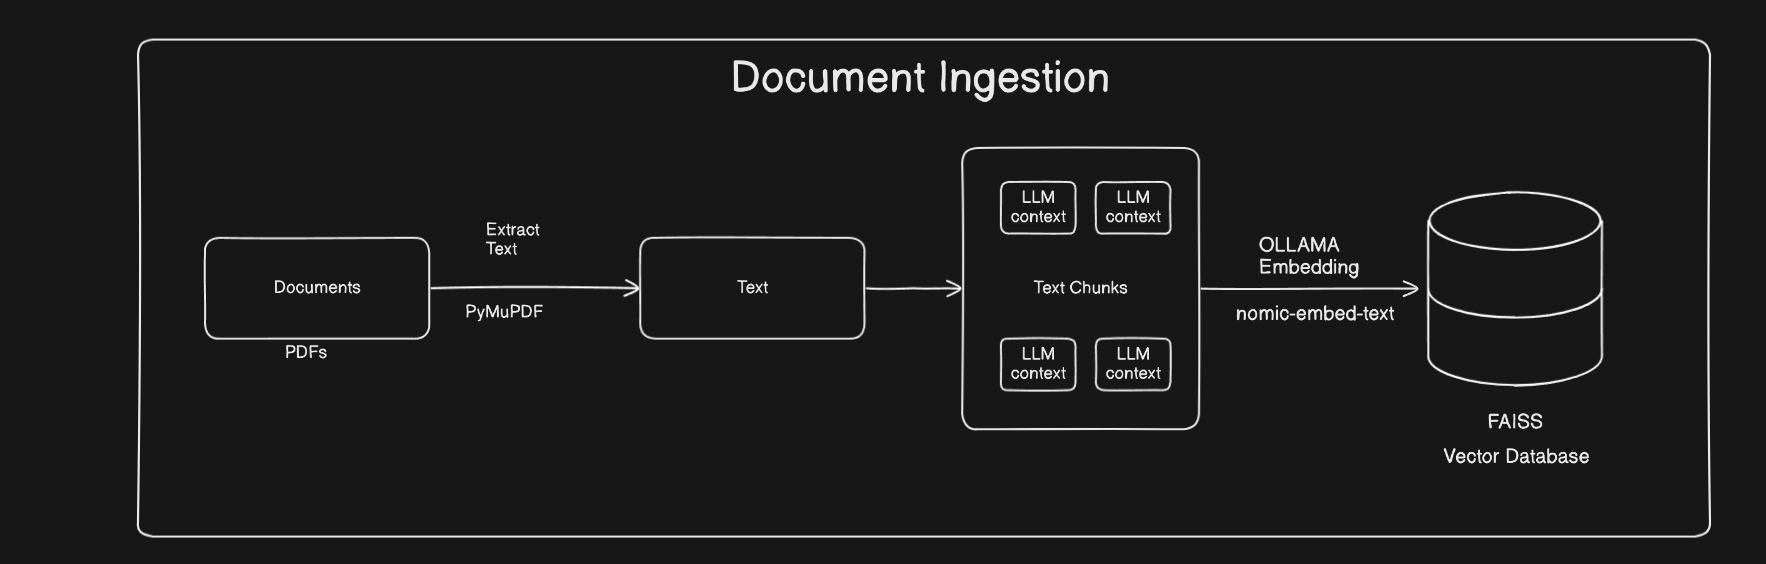

In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("/content/rag_dataset/gym_supplements/1. Analysis of Actual Fitness Supplement.pdf")

docs = loader.load()

In [ ]:
doc = docs[0]
print(doc.metadata)
print('\n\n')
print(doc.page_content)

In [ ]:
import os

pdfs = []
for root, dirs, files in os.walk('/content/rag_dataset'):
    print(root, dirs, files)
    for file in files:
        if file.endswith('.pdf'):
            pdfs.append(os.path.join(root, file))

In [ ]:
pdfs

In [ ]:
docs = []
for pdf in pdfs:
    loader = PyMuPDFLoader(pdf)
    pages = loader.load()

    docs.extend(pages)

In [ ]:
len(docs)

### **Document Chunking**

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

chunks = text_splitter.split_documents(docs)

In [ ]:
len(docs), len(chunks)

In [ ]:
len(docs[0].page_content), len(chunks[0].page_content)

In [ ]:
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-4o-mini")

len(encoding.encode(docs[0].page_content)), len(encoding.encode(chunks[0].page_content))

### **Document Vector Embedding**

In [ ]:
from langchain_ollama import OllamaEmbeddings

import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [ ]:
embeddings = OllamaEmbeddings(model='nomic-embed-text')
single_vector = embeddings.embed_query("this is some text data")


In [ ]:
len(single_vector)

In [ ]:
index = faiss.IndexFlatL2(len(single_vector))
index.ntotal, index.d

In [ ]:
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [ ]:
len(chunks)

In [ ]:
# help(vector_store)

In [ ]:
ids = vector_store.add_documents(documents=chunks)

In [ ]:
len(ids)

In [ ]:
vector_store.index_to_docstore_id

In [ ]:
# # store vector database
db_name = "health_supplements"
vector_store.save_local(db_name)

# load vector database
new_vector_store = FAISS.load_local(db_name, embeddings=embeddings, allow_dangerous_deserialization=True)
len(new_vector_store.index_to_docstore_id)

### **Retreival**

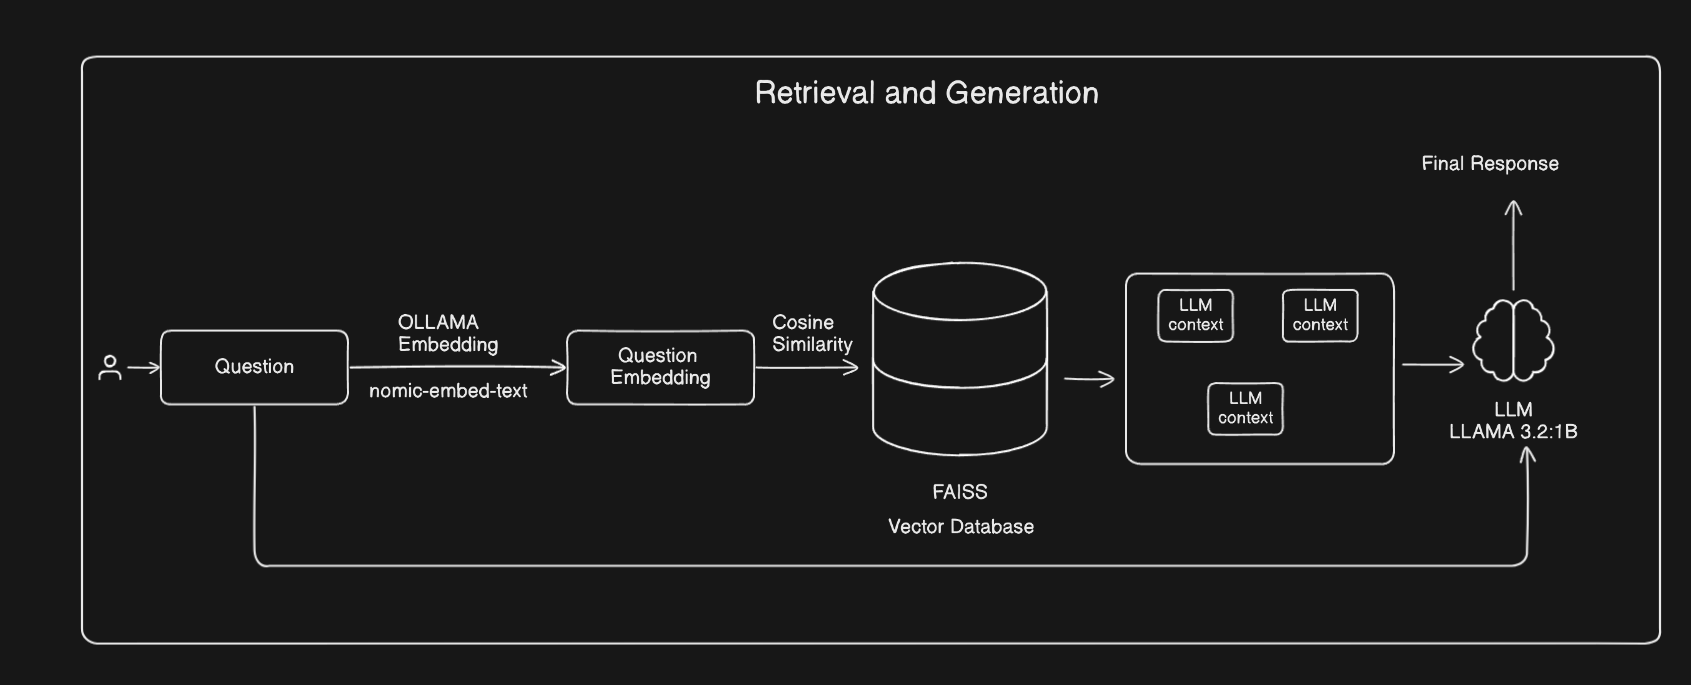

In [ ]:
question = "what is used to gain muscle mass?"
docs = vector_store.search(query=question, search_type='similarity')

for doc in docs:
    print(doc.page_content)
    print("\n\n")

In [ ]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs = {'k': 3,
                                                                          'fetch_k': 100,
                                                                          'lambda_mult': 1})

In [ ]:
docs = retriever.invoke(question)

for doc in docs:
    print(doc.page_content)
    print("\n\n")


In [ ]:
# question = "what is used to reduce weight?"
# question = "what are side effects of supplements?"
# question = "what are the benefits of supplements?"
question = "what are the benefits of BCAA supplements?"
docs = retriever.invoke(question)


### **RAG with Llama 3.2 on Ollama**

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

from langchain_ollama import ChatOllama

In [ ]:
model = ChatOllama(model="llama3.2:1b")

model.invoke("hi")

In [ ]:
prompt = hub.pull("rlm/rag-prompt")

In [ ]:
prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know.
    Answer in bullet points. Make sure your answer is relevant to the question and it is answered from the context only.
    Question: {question}
    Context: {context}
    Answer:
"""

prompt = ChatPromptTemplate.from_template(prompt)
prompt

In [ ]:
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

print(format_docs(docs))

In [ ]:
rag_chain = (
    {"context": retriever|format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
# question = "what is used to gain muscle mass?"
# question = "what is used to reduce weight?"
# question = "what are side effects of supplements?"
# question = "what are the benefits of supplements?"
# question = "what are the benefits of BCAA supplements?"

question = "what is used to increase mass of the Earth?"

output = rag_chain.invoke(question)
print(output)




* UI-based Enhancements
    - Streamlit Application
    - Chrome Plugin
* Evaluation and Tracing:
    - RAGAS
        - Metrics include: faithfulness, answer relevancy, context precision, context recall
    - LangSmith
* Indexing:
    - Document Ingestion
        - Text Preprocessing
        - Fix auto-generated transcripts
        - Convert other language transcripts into English    
    - Text Splitting
        - Semantic Chunker vs Recursive Chunker
    - Vector Store
        - Cloud-based stores such as PineCone.
* Retrieval:
    - Pre-Retrieval
        - Query rewriting using LLM
        - Multi-query generation
        - Domain-aware routing
    - During Retrieval
        - *Maximal Marginal Relevance (MMR)*: This technique diversifies search results by considering both relevance to the query and novelty among the retrieved documents, preventing the return of highly similar and redundant information.
        - *Hybrid Retrieval*: Combines semantic search with traditional keyword-based search for a more comprehensive retrieval approach.
        - Reranking
    - Post-Retrieval
        - Contextual Compression
* Augmentation:
    - Prompt Templating
    - Answer Grounding
    - Context Window Optimization
* Generation:
    - Answer with Citation
    - Guardrailing
* System Design:
    - Multimodal
    - Agentic
    - Memory-based




## **References and Credits**

* [Build a Retrieval Augmented Generation (RAG) App: Part 1](https://python.langchain.com/docs/tutorials/rag/)
* [Generative AI Using LangChain by CampusX](https://www.youtube.com/playlist?list=PLKnIA16_RmvaTbihpo4MtzVm4XOQa0ER0)
* [Build a Private Chat My PDF Data RAG System with LangChain, Ollama, FAISS Vector Store & Llama 3.2](https://www.youtube.com/watch?v=HTbt71CCcyg)
* [Retrieval Augmented Generation (RAG) with Langchain: A Complete Tutorial](https://www.youtube.com/watch?v=YLPNA1j7kmQ)
* [Implementing RAG in LangChain with Chroma: A Step-by-Step Guide](https://medium.com/@callumjmac/implementing-rag-in-langchain-with-chroma-a-step-by-step-guide-16fc21815339)
* [Introduction to LangChain](https://www.geeksforgeeks.org/artificial-intelligence/introduction-to-langchain/)
* [FAISS Vs ChromaDB](https://medium.com/@sujathamudadla1213/chromadb-vsfaiss-65cdae3012ab)
* [Practical comparison between FAISS and ChromaDB](https://medium.com/@stepkurniawan/comparing-faiss-with-chroma-vector-stores-0953e1e619eb)